In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
from itertools import islice
from pathlib import Path
from typing import Iterator

import matplotlib.pyplot as plt
import numpy as np
import tiktoken
import torch
import tqdm
from jaxtyping import Integer

from kernels.data import open_mmap
from kernels.pytorch.cross_entropy import cross_entropy
from kernels.transformer import Transformer

## Data

In [32]:
DATA_DIR = Path("/home/samgd/Code/cs336_assign2/kernels/data/owt/tokens/")
TRAIN_BIN = DATA_DIR / "owt_train.uint16.bin"
VALID_BIN = DATA_DIR / "owt_valid.uint16.bin"

SEQ_LEN = 256
BATCH_SIZE = 32
TOTAL_TOKENS = 100_000_000
EPOCHS = 10
EVAL_TOKENS = 100_000

STEPS_PER_EPOCH = TOTAL_TOKENS//(SEQ_LEN*BATCH_SIZE*EPOCHS)
EVAL_STEPS = max(EVAL_TOKENS//(SEQ_LEN*BATCH_SIZE), 1)

print(f"{STEPS_PER_EPOCH=}, {EVAL_STEPS=}")

STEPS_PER_EPOCH=1220, EVAL_STEPS=12


In [33]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, seq_len: int, path: Path):
        super().__init__()
        self.seq_len = seq_len
        self.path = path
        # Lazy load to avoid worker processes loading array into memory when pickling Dataset.
        self._data = None 

    @property
    def data(self):
        if self._data is None:
            self._data = open_mmap(self.path)
        return self._data

    def __getitem__(self, idx: int) -> tuple[Integer[torch.Tensor, "batch seq_len"], Integer[torch.Tensor, "batch seq_len"]]:
        x = torch.tensor(self.data[idx:idx+self.seq_len]).int()
        y = torch.tensor(self.data[idx + 1:idx+self.seq_len + 1]).int()
        return x, y

    def __len__(self) -> int:
        # Targets require `idx + 1:idx + seq_len + 1` to exist so effectively:
        # `len(self.data) - (self.seq_len + 1) + 1`
        return max(len(self.data) - self.seq_len, 0)

In [34]:
train_ds = Dataset(SEQ_LEN, TRAIN_BIN)
valid_ds = Dataset(SEQ_LEN, VALID_BIN)

In [35]:
train_sampler = torch.utils.data.RandomSampler(
    train_ds, 
    replacement=True,
    num_samples=BATCH_SIZE*STEPS_PER_EPOCH,
)

train_dl = torch.utils.data.DataLoader(
    dataset=train_ds, 
    batch_size=BATCH_SIZE, 
    num_workers=1, 
    sampler=train_sampler,
    pin_memory=True,
)

In [36]:
valid_sampler = torch.utils.data.RandomSampler(
    valid_ds, 
    replacement=True,
    num_samples=BATCH_SIZE*EVAL_STEPS,
)

valid_dl = torch.utils.data.DataLoader(
    dataset=valid_ds, 
    batch_size=BATCH_SIZE, 
    num_workers=1, 
    sampler=valid_sampler,
    pin_memory=True,
)

## Model

In [37]:
num_embeddings = tiktoken.get_encoding("gpt2").max_token_value + 1
depth = 18
d_model = 512
d_ff = int(64*((d_model*4*(2/3))//64))

n_head = d_model // 64

print(f"{num_embeddings=}, {d_model=}, {d_ff=}, {n_head=}")

num_embeddings=50257, d_model=512, d_ff=1344, n_head=8


In [38]:
model = Transformer("triton", num_embeddings, depth, d_model, n_head, d_ff, device="cuda")

In [39]:
num_params_mil = sum([p.numel() for p in model.parameters()]) / 1e6
print(f"{num_params_mil=:5.1f}M")

num_params_mil=107.5M


## Optim

In [40]:
lr = 3e-4

warmup_steps = 0.01*EPOCHS*STEPS_PER_EPOCH

In [41]:
opt = torch.optim.AdamW(params=model.parameters(), lr=lr)

In [42]:
warmup_sched = torch.optim.lr_scheduler.LinearLR(
    opt,
    start_factor=lr*0.01,
    end_factor=1.0,
    total_iters=warmup_steps,
)

cos_sched = torch.optim.lr_scheduler.CosineAnnealingLR(
    opt,
    T_max=EPOCHS*STEPS_PER_EPOCH - warmup_steps,
    eta_min=lr*0.01,
)

lr_sched = torch.optim.lr_scheduler.SequentialLR(
    opt,
    schedulers=[warmup_sched, cos_sched],
    milestones=[warmup_steps],
)

## Training Loop

In [43]:
losses = []
lrs = []

valid_epoch_losses = []

for epoch in range(EPOCHS):
    # train
    model.train()
    with tqdm.tqdm(desc=f"epoch {epoch + 1}/{EPOCHS}, train", total=len(train_dl)) as pbar:
        for i, (x, y) in enumerate(train_dl):
            model.zero_grad(set_to_none=True)
            
            x = x.to("cuda")
            y = y.to("cuda")
    
            with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
                out = model(x)
            
            loss = cross_entropy(out.flatten(end_dim=1), y.flatten()).mean()
            
            loss.backward()
            opt.step()
            lr_sched.step()
            
            losses.append(loss.item())
            lrs.append(lr_sched.get_last_lr())
            
            pbar.set_postfix_str(f"loss={losses[-1]:5.3f}")
            pbar.update(1)

    # validate
    model.eval()
    with tqdm.tqdm(desc=f"epoch {epoch + 1}/{EPOCHS}, valid", total=len(valid_dl)) as pbar:
        valid_losses = []
        for i, (x, y) in enumerate(valid_dl):
            x = x.to("cuda")
            y = y.to("cuda")

            with torch.no_grad():
                with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
                    out = model(x)
            
            loss = cross_entropy(out.flatten(end_dim=1), y.flatten()).mean()
            valid_losses.append(loss.item())

            pbar.set_postfix_str(f"valid_loss={valid_losses[-1]:5.3f}")
            pbar.update(1)

        valid_epoch_losses.append(sum(valid_losses) / len(valid_losses))
        pbar.set_postfix_str(f"valid_loss={valid_epoch_losses[-1]:5.3f}")

epoch 1/10, train:  10%|███████▎                                                                  | 121/1220 [00:29<04:22,  4.19it/s, loss=7.275]/home/samgd/Code/cs336_assign2/kernels/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
epoch 10/10, valid: 100%|██████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.71it/s, valid_loss=4.157]


## Loss Plots

In [44]:
valid_epoch_steps = [i*len(train_dl) for i in range(1, EPOCHS + 1)]

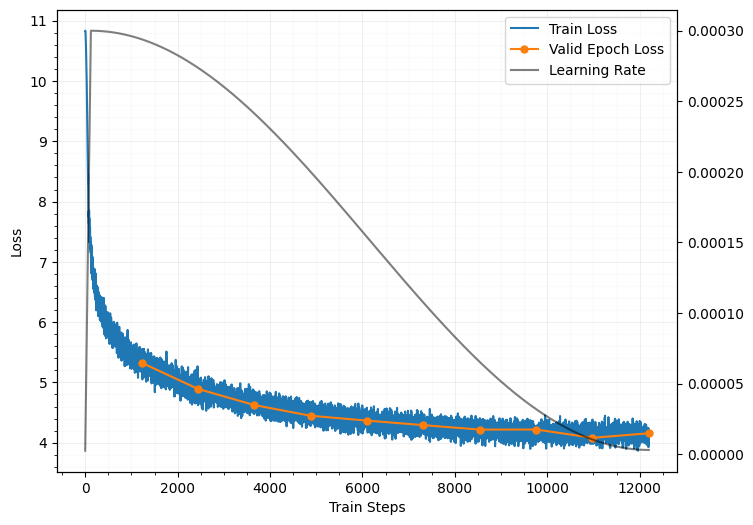

In [45]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(losses, label="Train Loss")
ax.plot(valid_epoch_steps, valid_epoch_losses, marker='o', markersize=5, label="Valid Epoch Loss")

ax2 = ax.twinx()
ax2.plot(lrs, color="black", alpha=0.5, label="Learning Rate")

# Combine ax and ax2 legends.
handles = []
labels = []
for a in [ax, ax2]:
    h, l = a.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)
ax.legend(handles, labels)

ax.set_xlabel("Train Steps")
ax.set_ylabel("Loss")

ax.grid(which="major", alpha=0.20)
ax.minorticks_on()
ax.grid(which="minor", alpha=0.05)

plt.show()